## Imports 

In [22]:
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold
from sklearn.linear_model import LogisticRegression, Ridge
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, make_scorer
from sklearn.feature_selection import SelectKBest, f_regression, RFECV
from sklearn.pipeline import Pipeline
from numpy import sqrt


## Data preparation

In [23]:
import os
from pathlib import Path
from sklearn.model_selection import train_test_split

# 0. Baseline

## 0.1 Linear Regression without Hyperparameter Optimization or Feature Selection

In [24]:
import pandas as pd
data_train = pd.read_csv('../data/processed/X_train_lr.csv')
data_test = pd.read_csv('../data/processed/X_test_lr.csv')
target_train = pd.read_csv('../data/processed/y_train_lr.csv')
target_test = pd.read_csv('../data/processed/y_test_lr.csv')


In [25]:
print(f"Data mean: {data_train.mean().mean()}, Data std: {data_train.std().mean()}")

Data mean: 0.01516306220733957, Data std: 0.9856880295944443


In [26]:
print(f"Class distribution: {target_train.value_counts(normalize=True)}")

Class distribution: DRK_YN
0         0.500186
1         0.499814
Name: proportion, dtype: float64


In [39]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

regressor = LogisticRegression(max_iter=10000, tol=1e-4, class_weight=None)
regressor.fit(data_train, target_train.values.ravel())
drk_prediction = regressor.predict(data_test)

acc_bl = accuracy_score(target_test, drk_prediction)
prc_bl = precision_score(target_test, drk_prediction)
rec_bl = recall_score(target_test, drk_prediction)
f1_bl = f1_score(target_test, drk_prediction,)
print(f'Accuracy: {acc_bl:.3f}')
print(f'Precision: {prc_bl:.3f}')
print(f'Recall: {rec_bl:.3f}')
print(f'F1 Score: {f1_bl:.3f}')



Accuracy: 0.728
Precision: 0.732
Recall: 0.721
F1 Score: 0.726


# 1. Random Search

In [33]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

param_dist = {
    'C': np.linspace(0.5, 1.5, 10),  
    'penalty': ['l2'],              
    'solver': ['lbfgs', 'newton-cholesky'], 
    'max_iter': [500]                
}

logreg = LogisticRegression(random_state=42)

f1_scorer = make_scorer(f1_score)

random_search = RandomizedSearchCV(
    logreg,
    param_distributions=param_dist,
    n_iter=15, 
    cv=3,
    scoring=f1_scorer,
    random_state=42,
    n_jobs=-1,
    verbose=2
)

random_search.fit(data_train, target_train.values.ravel())

best_params = random_search.best_params_
best_score = random_search.best_score_

best_model = random_search.best_estimator_
drk_prediction = best_model.predict(data_test)

acc_rs = accuracy_score(target_test, drk_prediction)
prc_rs = precision_score(target_test, drk_prediction)
rec_rs = recall_score(target_test, drk_prediction)
f1_rs = f1_score(target_test, drk_prediction)

print("Best parameters:", best_params)
print(f"Best cross-validated F1 score: {best_score:.3f}")
print(f'Accuracy: {acc_rs:.3f}')
print(f'Precision: {prc_rs:.3f}')
print(f'Recall: {rec_rs:.3f}')
print(f'F1 Score: {f1_rs:.3f}')


Fitting 3 folds for each of 15 candidates, totalling 45 fits
[CV] END C=1.3888888888888888, max_iter=500, penalty=l2, solver=newton-cholesky; total time=   8.2s
[CV] END ......C=0.5, max_iter=500, penalty=l2, solver=lbfgs; total time=   9.8s
[CV] END ......C=0.5, max_iter=500, penalty=l2, solver=lbfgs; total time=  10.5s
[CV] END C=1.3888888888888888, max_iter=500, penalty=l2, solver=newton-cholesky; total time=   6.4s
[CV] END ......C=0.5, max_iter=500, penalty=l2, solver=lbfgs; total time=  15.9s
[CV] END C=1.3888888888888888, max_iter=500, penalty=l2, solver=newton-cholesky; total time=   6.5s
[CV] END C=1.2777777777777777, max_iter=500, penalty=l2, solver=newton-cholesky; total time=   6.5s
[CV] END C=1.2777777777777777, max_iter=500, penalty=l2, solver=newton-cholesky; total time=   4.6s
[CV] END C=1.2777777777777777, max_iter=500, penalty=l2, solver=newton-cholesky; total time=   4.1s
[CV] END C=0.5, max_iter=500, penalty=l2, solver=newton-cholesky; total time=   4.2s
[CV] END C=

/opt/anaconda3/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END C=0.9444444444444444, max_iter=500, penalty=l2, solver=newton-cholesky; total time=   4.0s
[CV] END C=0.9444444444444444, max_iter=500, penalty=l2, solver=newton-cholesky; total time=   4.7s
[CV] END C=1.5, max_iter=500, penalty=l2, solver=newton-cholesky; total time=   4.1s
[CV] END C=1.5, max_iter=500, penalty=l2, solver=newton-cholesky; total time=   4.0s
[CV] END C=0.7222222222222222, max_iter=500, penalty=l2, solver=lbfgs; total time=   4.8s
[CV] END C=0.7222222222222222, max_iter=500, penalty=l2, solver=lbfgs; total time=   5.1s
[CV] END C=1.5, max_iter=500, penalty=l2, solver=newton-cholesky; total time=   2.9s
[CV] END C=0.7222222222222222, max_iter=500, penalty=l2, solver=lbfgs; total time=   7.3s
Best parameters: {'solver': 'lbfgs', 'penalty': 'l2', 'max_iter': 500, 'C': 1.5}
Best cross-validated F1 score: 0.724
Accuracy: 0.728
Precision: 0.732
Recall: 0.721
F1 Score: 0.726


# 2. Grid Search

Fitting 5 folds for each of 56 candidates, totalling 280 fits
Best Parameters: {'logreg__C': 10.0, 'logreg__penalty': 'l1', 'logreg__solver': 'liblinear'}
Test Set Performance:
Accuracy: 0.728
Precision: 0.731
Recall: 0.720
F1: 0.726


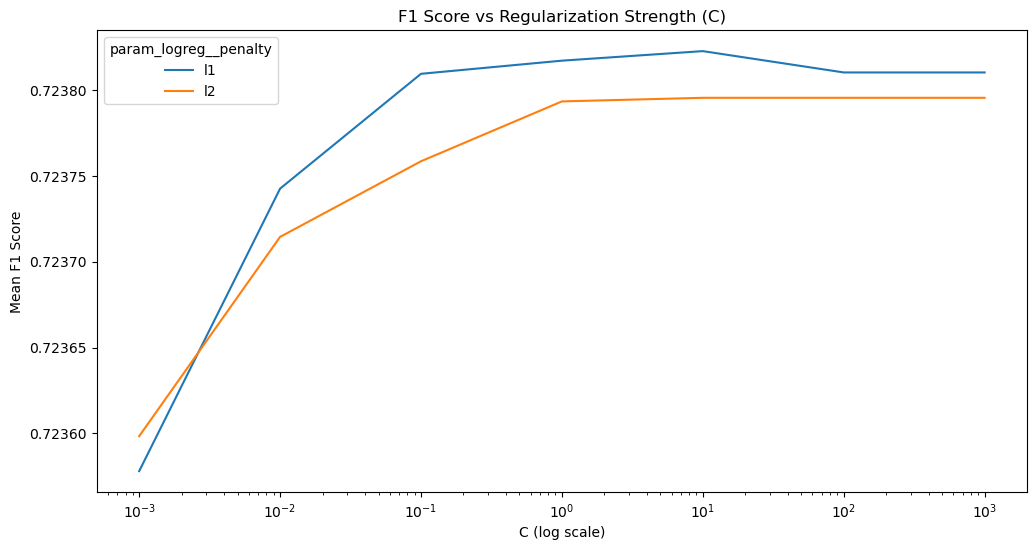

In [40]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, StratifiedKFold
import numpy as np

logreg_pipe = Pipeline([
   ('logreg', LogisticRegression(
        random_state=42,
        class_weight=None,
        max_iter=10000,       
        tol=1e-3,   
        warm_start=False     
    ))
])

param_grid = [
    {
        'logreg__penalty': ['l1', 'l2'],
        'logreg__C': np.logspace(-3, 3, 7), 
        'logreg__solver': ['liblinear', 'saga']  
    },
    {
        'logreg__penalty': ['l2'],
        'logreg__C': np.logspace(-3, 3, 7),
        'logreg__solver': ['lbfgs', 'newton-cg', 'sag', 'newton-cholesky']  
    }
]

grid_search = GridSearchCV(
    estimator=logreg_pipe,
    param_grid=param_grid,
    scoring={
        'accuracy': 'accuracy',
        'f1': f1_scorer,
        'precision': make_scorer(precision_score, average='binary'),
        'recall': make_scorer(recall_score, average='binary')
    },
    refit='f1',
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42), 
    n_jobs=-1,
    verbose=1,
    error_score='raise'
)

grid_search.fit(data_train, target_train.values.ravel())

best_model = grid_search.best_estimator_
drk_prediction = best_model.predict(data_test)

metrics = {
    'accuracy': accuracy_score(target_test, drk_prediction),
    'precision': precision_score(target_test, drk_prediction),
    'recall': recall_score(target_test, drk_prediction),
    'f1': f1_score(target_test, drk_prediction)
}

results_df = pd.DataFrame(grid_search.cv_results_)
best_params = grid_search.best_params_

print(f"Best Parameters: {best_params}")
print("Test Set Performance:")
for metric, value in metrics.items():
    print(f"{metric.capitalize()}: {value:.3f}")

plt.figure(figsize=(12, 6))
sns.lineplot(
    data=results_df[results_df.param_logreg__solver == best_params['logreg__solver']],
    x='param_logreg__C', 
    y='mean_test_f1',
    hue='param_logreg__penalty'
)
plt.xscale('log')
plt.title('F1 Score vs Regularization Strength (C)')
plt.xlabel('C (log scale)')
plt.ylabel('Mean F1 Score')
plt.show()


In [42]:
coefficients = best_model.named_steps['logreg'].coef_[0]
feature_importance = pd.DataFrame({
    'Feature': data_train.columns,
    'Weight': coefficients
}).sort_values('Weight', ascending=False)

print(feature_importance.head(10))

                   Feature    Weight
34           sex_Male_True  0.901501
20               gamma_GTP  0.610729
12               HDL_chole  0.410588
21        SMK_stat_type_cd  0.381483
1                   height  0.272191
27           AST_ALT_ratio  0.201578
18                SGOT_AST  0.191200
24  mean_arterial_pressure  0.180159
22                     BMI  0.171554
3                waistline  0.121899


Visualizing Error Types (Confusion Matrix & PCA)...


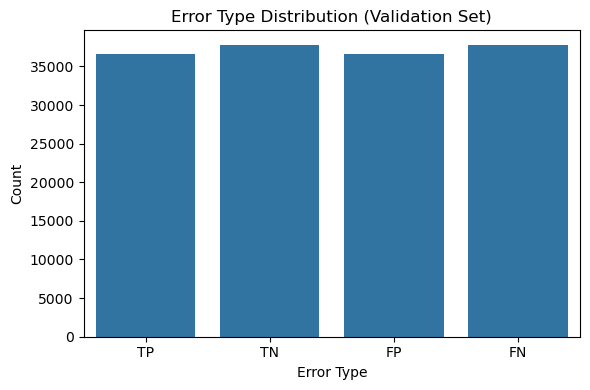

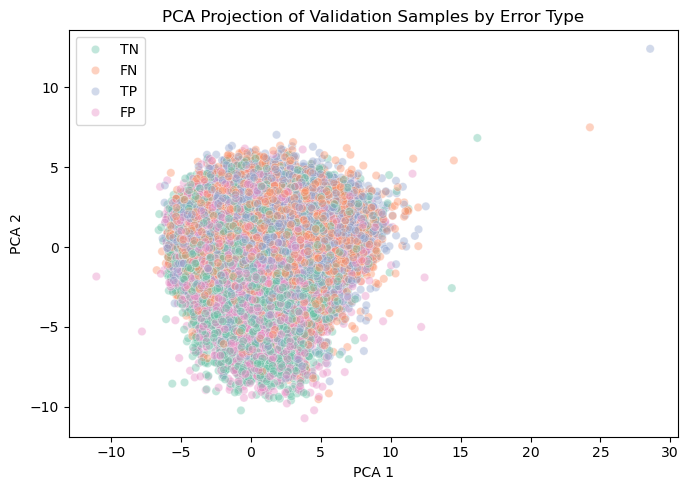


 Analyzing Error Samples (FN and FP)...

 Plotting Feature Distributions (FN)...


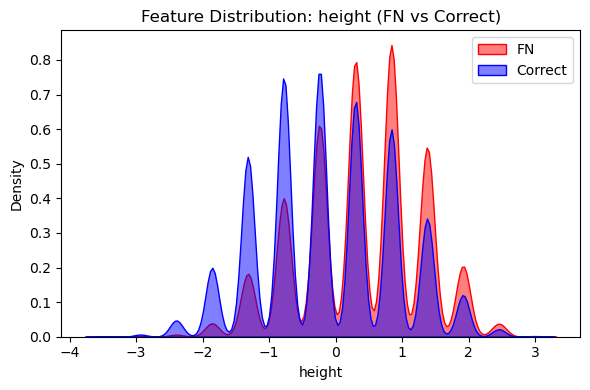

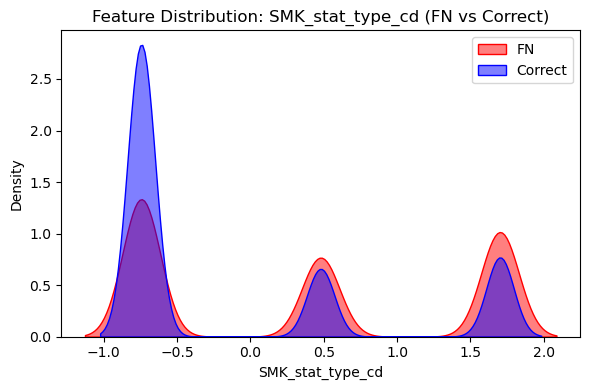

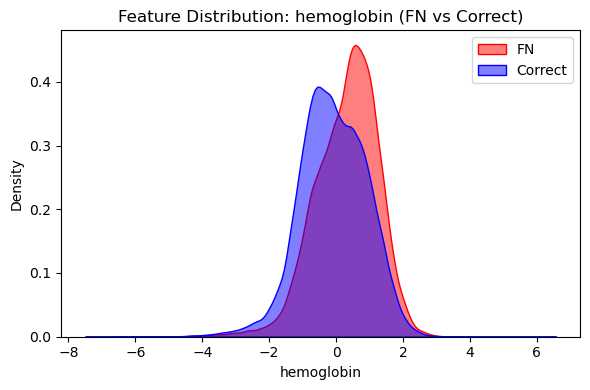


 Plotting Feature Distributions (FP)...


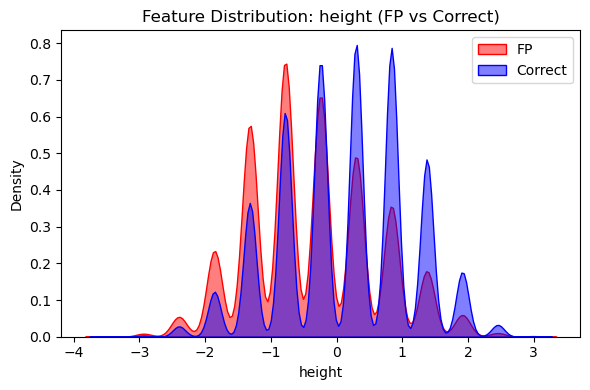

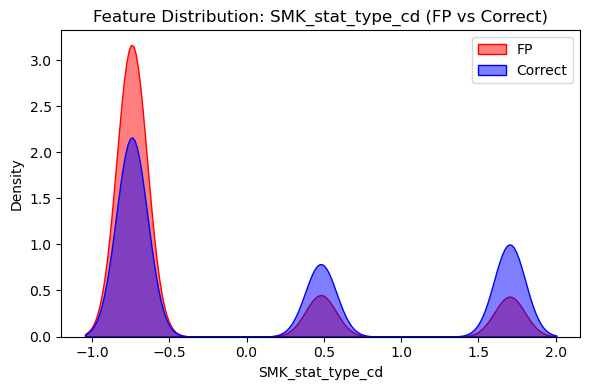

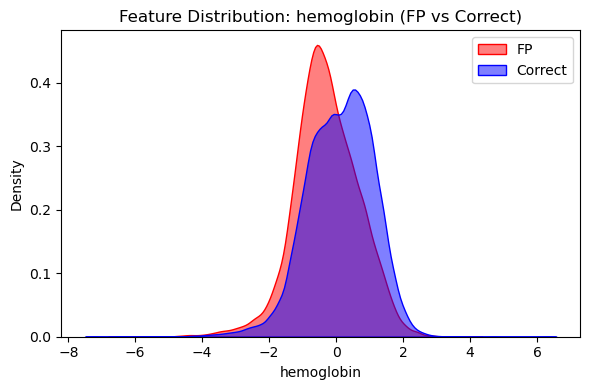

In [44]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
from scripts.evaluate_models import run_error_analysis
import pandas as pd

X_val_lr = pd.read_csv('../data/processed/X_val_lr.csv')
y_val_lr = pd.read_csv('../data/processed/y_val_lr.csv').squeeze()  


results_lr = run_error_analysis(X_val_lr, y_val_lr, drk_prediction)


